In [3]:
import numpy as np
from scipy import sparse
import random
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import time
from tqdm import tqdm

%matplotlib inline

# Speeding Up Inner Product Sort

Dr. Warnick's algorithm is good, but it can be customized to working on big sparse matrices.

Here is his algorithm copied over from matlab. You may notice that he used a heuristic to speed it up. The heuristic worked in his example, but didn't work well when I tried it, so I got rid of it. (This slowed down the algorithm.)

In [4]:
def ipsortDraft(A,alpha=.5):
    """ Group similar rows and columns of a matrix together

        Parameters
        ----------
        A: (mxn ndarray) boolian matrix to sort
        alpha: (float) parameter in 0 < alpha <1        

        Returns
        -------
        Asort: (mxn ndarray) sorted matrix
    """
    m,n = A.shape
    mark = 0 #Current Column 
    
    perCol = np.arange(n) #Variable to store column permutations
    perRow = np.arange(m) #Variable to store row permutations
    
    while mark < n-2:
        #The unexplored right side of the matrix
        APart = A[:,mark+1:n] 
        perColPart = perCol[mark+1:n]
        
        #Find similar columns by using an inner product
        score = np.inner(A[:,mark],APart.T) 
        permuC = np.argsort(score)[::-1]
        
        #Rearrange A to bring similar columns to the left
        A[:,mark+1:n] = APart[:,permuC] 
        perCol[mark+1:n] = perColPart[permuC]
        
        #Find the end of the current cluster
        fin = np.argmax(np.abs(np.diff(score[permuC]))) 
        
        #The triple quotes below is how Dr. Warnick sorted the rows. 
        #He did not use an inner product, instead, he took a row sum,
        #organizing rows by number of entries in that row.
        """
        permuR = np.argsort(np.sum(APart[:mark,:fin],axis=1))[::-1]
        A[:mark,:] = A[permuR,:] #Move rows together
        perRow[:mark] = perRow[permuR]
        """
        mark = mark + fin + 2

    #I decided to run the inner product sort on the rows by running
    #the loop above on the transposed matrix. This sorts both rows 
    #and columns using an inner product

    A = A.T
    mark = 0    
    while mark < m-2:
        #The unexplored right side of the matrix
        APart = A[:,mark+1:m] 
        perColPart = perCol[mark+1:m]
        
        #Finding similar columns with an inner product
        score = np.inner(A[:,mark],APart.T) 
        permuC = np.argsort(score)[::-1]
        
        #Rearrange A to bring similar columns to the left
        A[:,mark+1:m] = APart[:,permuC] 
        perCol[mark+1:m] = perColPart[permuC]
        
        #Find the end of the current cluster
        fin = np.argmax(np.abs(np.diff(score[permuC]))) 
        mark = mark + fin + 2
    Asort = A.T

    return Asort

### Some Useful Functions

 The functions below generate a matrix with a shuffled block diagonal structure and graph matrix structure.
 
 Let's see what this algorithm can do:

In [5]:
def shuffledMatrix(N=3):
    """ Creates a N^2 by N^2 matrix with NxN blocks 
        of ones along the diagonal """
 
    M = np.zeros((N**2,N**2))
    for i in range(N):
        j = N*i
        M[j:j+N,j:j+N] = np.ones((N,N))

    
    rows = np.arange(N**2)
    cols = np.arange(N**2)
    np.random.shuffle(rows)
    np.random.shuffle(cols)
    shuffM = M[:,cols]
    shuffM = shuffM[rows,:]
    return shuffM

def plot_coo_matrix(m):
    """ Plots nonzero entries of sparse array m as black pixels
        Credit to:
        https://stackoverflow.com/questions/22961541/
        python-matplotlib-plot-sparse-matrix-pattern
    """

    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='white')
    ax.plot(m.col, m.row, marker=',', color='black', lw=0,linestyle="")
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

In [18]:
A = shuffledMatrix()
print(A)

[[1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0.]]


In [19]:
print(ipsortDraft(A))

[[1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0.]]


Notice that the block structure is revealed by ipsortDraft( ). What about bigger matrices?

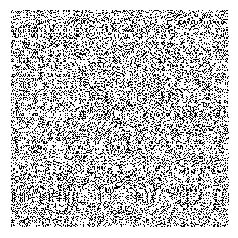

In [20]:
B = shuffledMatrix(N=25) #This generates a (25)^2 X (25)^2 matrix
plot_coo_matrix(B)
plt.show()

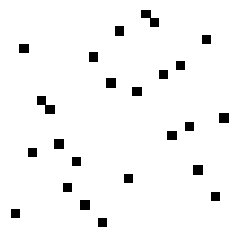

In [21]:
Bsort = ipsortDraft(B)
plot_coo_matrix(Bsort)
plt.show()

Sorted! All of the blocks are grouped together. It's amazing! Now for the issues:

In [22]:
B = shuffledMatrix('N=1000') #N=1000 is too big to even load.
#I put it in a string so you don't run it and kill the kernel

We will time ipsortDraft to get an idea of how fast it is.

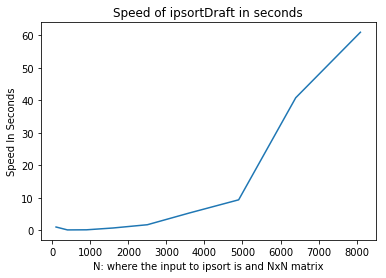

In [85]:
def timeIpsortDraft(M):
    t0 = time.time()        
    m = ipsortDraft(M)
    t1 = time.time()
    return t1-t0

times = []
N=10*(np.arange(9)+1)

for i in N:
    M = shuffledMatrix(i)
    t = timeIpsortDraft(M)
    times.append(t)
    
plt.plot(N*N,times)
plt.title("Speed of ipsortDraft in seconds")
plt.ylabel("Speed In Seconds")
plt.xlabel("N: where the input to ipsort is and NxN matrix")
plt.show()

Now we'll try to speed it up. Let's generate a large sparse matrix.

In [6]:
def shuffSparseArray(M=100,N=100):

    A = sparse.dok_matrix((M**2,N**2))
    secureRandom = random.SystemRandom()
    unusedCol = list(np.arange(M**2)) #List of empty columns
   
    while len(unusedCol)!=0:

        #Form a column with three 1s placed randomly at entryInd
        entryInd = np.random.randint(M**2,size=int(M/3))
        
        #Choose R random places to put this col 
        R = np.random.randint(N/2,high=N)
        if len(unusedCol) < N: 
            R = len(unusedCol)
    
        for i in range(R):
            col = secureRandom.choice(unusedCol)
            unusedCol.remove(col)
            for j in range(len(entryInd)):
                A[entryInd[j],col] = 1

    return A        

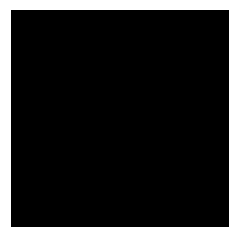

In [15]:
Big = shuffSparseArray'(N=500,M=500)' #This takes about 20 minutes to run. Remove the quotes to run it

plot_coo_matrix(Big)

In [16]:
import sys
sizeBig = sys.getsizeof(Big)/1e9
print('The matrix, Big, takes up {} Gigabytes'.format(sizeBig))

The matrix, Big, takes up 1.610613032 Gigabytes


The above matrix is similar in size to the medical data. It has 62 Billion cells and 40 Million non zero entries. Eventually, we will run our sorting algorithm on it.

We will time column permutations to see which format of sparse matrixes is the fastest.

In [17]:
permu = np.random.randint(500**2)

t0 = time.time()
B = Big[:,permu]
t1 = time.time()

print("Dictionary of Keys matrix column permutation time:    {}".format(t1-t0))

Big = Big.tocsr()
t0 = time.time()
B = Big[:,permu]
t1 = time.time()

print("Compressed Sparse Row matrix column permutation time: {}".format(t1-t0))

Big = Big.tocsc()
t0 = time.time()
B = Big[:,permu]
t1 = time.time()

print("Compressed Sparse Col matrix column permutation time: {}".format(t1-t0))

Dictionary of Keys matrix column permutation time:    0.607156991959
Compressed Sparse Row matrix column permutation time: 0.391940116882
Compressed Sparse Col matrix column permutation time: 0.0248370170593


CSC is the fastest. We will find the fastest method for computing the dot product next.

In [18]:
#Time dotting the first column of Big with the rest of Big

print("\tCSR\n"+"----"*5)
Big.tocsr()

t0 = time.time()
B = Big[:,0].transpose().dot(Big[:,1:])
t1 = time.time()

print("Scipy .dot( ) time: \t{}".format(t1-t0))

t0 = time.time()
B = (sparse.diags(Big[:,0].toarray().ravel())*Big[:,1:]).sum(axis=0)
t1 = time.time()

print("Diagonal array time: \t{}".format(t1-t0))

t0 = time.time()
B = np.dot(Big[:,0].transpose(),Big[:,1:])
t1 = time.time()

print("Numpy dot funct time: \t{}".format(t1-t0))

print("\tCSC\n"+"----"*5)
Big.tocsc()

t0 = time.time()
B = Big[:,0].transpose().dot(Big[:,1:])
t1 = time.time()

print("Scipy .dot( ) time: \t{}".format(t1-t0))

t0 = time.time()
B = (sparse.diags(Big[:,0].toarray().ravel())*Big[:,1:]).sum(axis=0)
t1 = time.time()

print("Diagonal array time: \t{}".format(t1-t0))

t0 = time.time()
B = np.dot(Big[:,0].transpose(),Big[:,1:])
t1 = time.time()

print("Numpy dot funct time: \t{}".format(t1-t0))


	CSR
--------------------
Scipy .dot( ) time: 	1.22076106071
Diagonal array time: 	1.65480899811
Numpy dot funct time: 	1.13857293129
	CSC
--------------------
Scipy .dot( ) time: 	1.10356712341
Diagonal array time: 	1.15409684181
Numpy dot funct time: 	1.10032320023


Scipy and numpy are about the same. We'll use scipy because it takes sligtly less characters to write. We'll use the csc format so we don't have to convert anything.

Next, we will look at sorting algorithms:

In [27]:
print("Data: {}".format(B.data))
print("Indices: {}".format(B.indices))

Data: [  1.   1.   1. ... 166. 166. 166.]
Indices: [248688 246862 246490 ...   4037   3693   1735]


It looks like after computing a dot product, the data and indice attributes are pre-sorted

In [48]:
M,N = B.shape
#We will time sorting the solution to the previous cell

t0 = time.time()
sortB = np.argsort(B.toarray().ravel())[::-1]
index = list(range(1)+list(sortB))
t1 = time.time()

print("argsort time: {}".format(t1-t0))

t0 = time.time()
#sortB = B.indices[::-1]
s = set(B.indices)
index = list(iters.chain(range(1),B.indices+1,iters.ifilter(lambda x: x not in s,range(len(B.indices)+1,250000))))
t1 = time.time()

print("Indices time: {}".format(t1-t0))


argsort time: 0.00927209854126
Indices time: 0.162091970444


In [44]:
len(sortB)



249999

In [22]:
t0 = time.time()
Big = Big.tocsc()
t1 = time.time()
print("CSC Conversion time in seconds: {}".format(t1-t0))

CSC Conversion time in seconds: 1.06973695755


After gathering all this information we are ready to write the algorithm.

In [7]:
def ipsort(A, sortRow=True,returnPermu=False,verbose=False):
    """ Group similar rows and columns of a matrix together

        Parameters
        ----------
        A: (mxn ndarray) sparse matrix of zeros and ones to sort
        sortRow: (bool) if sortRow=false, the algorithm sorts columns ONLY
        returnPermu: (bool) if returnPermu=True, the function returns the 
                   permutation vectors and grouping vectors
        verbose: (bool) if verbose=True, the function prints it's progress 
                        through the matrix
        Returns
        -------
        Asorted: (mxn ndarray) permuted A matrix
        perCol (1xn ndarray) column permutations
        perRow = (1xm ndarray) row permutations
        rowGroups = (list) stores the indices that begin each row grouping
        colGroups = (list) stores the indices that begin each row grouping
        
    """
    #Variables to keep track of progress
    M,N = A.shape
    mark = 0
    progress = 0
    printStepSize = N//20
    
    #Variables to store row and column permutations
    perCol = np.arange(N) 
    perRow = np.arange(M) 
    
    #Variables to store the beginnings of each grouping
    rowGroups = [0] 
    colGroups = [0]
    
    A = A.tocsc()
    while mark < N-2:
        #Compute column similarity with a dot product
        scores = A[:,mark].transpose().dot(A[:,mark+1:])
        
        #Move the most similar columns to the front
        sort = np.argsort(scores.toarray().ravel())[::-1] 
        permu = list(range(mark+1)+list(sort+mark+1))
        A = A[:,permu]
        perCol = perCol[permu]
        
        #Find the end of the grouping
        fin = np.argmax(np.abs(np.diff(scores.toarray()[:,sort])))
        mark += fin + 2
        colGroups.append(mark)
        
        if verbose:
            if mark - progress > printStepSize:
                steps = progress//printStepSize
                print("Column progress: \t{}".format('%'*steps) + '-'*(20-steps-2) +'|')
                progress += printStepSize
            
        
    #Repeat the above algorithm on the transposed matrix
    if sortRow:
        mark = 0
        progress = 0
        printStepSize = M//20
        
        A = A.transpose()#Transpose and run the algorithm above
        
        while mark < N-2:
            #Compute column similarity with a dot product
            scores = A[:,mark].transpose().dot(A[:,mark+1:])

            #Move the most similar columns to the front
            sort = np.argsort(scores.toarray().ravel())[::-1] 
            permu = list(range(mark+1)+list(sort+mark+1))
            A = A[:,permu]
            perRow = perRow[permu]

            #Find the end of the grouping
            fin = np.argmax(np.abs(np.diff(scores.toarray()[:,sort])))
            mark += fin + 2
            rowGroups.append(mark)
            
            if verbose:
                if mark - progress > printStepSize:
                    steps = progress//printStepSize
                    print("Row progress: \t\t{}".format('%'*steps) + '-'*(20-steps-2) +'|')
                    progress += printStepSize
                    
        A = A.transpose() #Transpose it back

    if returnPermu:
        return A,perCol,perRow,colGroups,rowGroups
    return A

Check if it works:

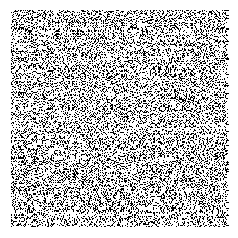

In [83]:
T = shuffledMatrix(N=25) #This generates a (25)^2 X (25)^2 matrix
plot_coo_matrix(T)

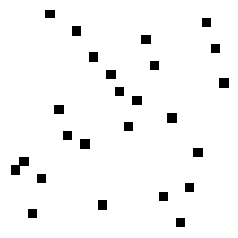

In [107]:
Tsort = ipsort(sparse.csc_matrix(T),sortRows=True)
plot_coo_matrix(Tsort)

We will compare it to our old algorithm

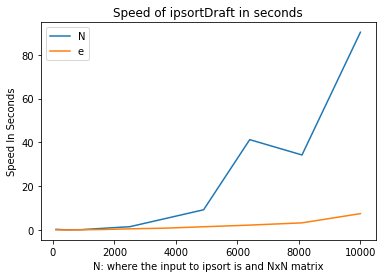

In [94]:
def timeIpsort(M):
    t0 = time.time()        
    m = ipsort(M)
    t1 = time.time()
    return t1-t0

draftTimes = []
newTimes = []
N=10*(np.arange(10)+1)

for i in N:
    M = shuffledMatrix(i)
    t = timeIpsortDraft(M)
    draftTimes.append(t)
    
    M = sparse.csc_matrix(M)
    t = timeIpsort(M)
    newTimes.append(t)
    
plt.plot(N*N,draftTimes)
plt.legend("Old Funct")
plt.plot(N*N,newTimes)
plt.legend("New Funct")
plt.title("Speed of ipsortDraft in seconds")
plt.ylabel("Speed In Seconds")
plt.xlabel("N: where the input to ipsort is and NxN matrix")
plt.show()

Clearly it is a lot faster. We will run it on the big matrix

Column progress: 	------------------|
Column progress: 	%-----------------|
Column progress: 	%%----------------|
Column progress: 	%%%---------------|
Column progress: 	%%%%--------------|
Column progress: 	%%%%%-------------|
Column progress: 	%%%%%%------------|
Column progress: 	%%%%%%%-----------|
Column progress: 	%%%%%%%%----------|
Column progress: 	%%%%%%%%%---------|
Column progress: 	%%%%%%%%%%--------|
Column progress: 	%%%%%%%%%%%-------|
Column progress: 	%%%%%%%%%%%%------|
Column progress: 	%%%%%%%%%%%%%-----|
Column progress: 	%%%%%%%%%%%%%%----|
Column progress: 	%%%%%%%%%%%%%%%---|
Column progress: 	%%%%%%%%%%%%%%%%--|
Column progress: 	%%%%%%%%%%%%%%%%%-|
Column progress: 	%%%%%%%%%%%%%%%%%%|
Row progress: 		------------------|
Row progress: 		%-----------------|
Row progress: 		%%----------------|
Row progress: 		%%%---------------|
Row progress: 		%%%%--------------|
Row progress: 		%%%%%-------------|
Row progress: 		%%%%%%------------|
Row progress: 		%%%%%%%---

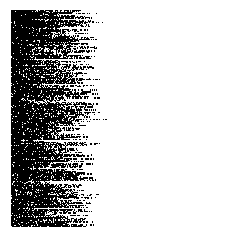

In [8]:
t0 = time.time()
BigSort = ipsort(Big,verbose=True)
t1 = time.time()
print("Sorting completed in {} hours".format((t1-t0)/60**2))
plot_coo_matrix(BigSort)

So our algorithm works on the big matrix! It takes a long time, but we can see that all of the similar columns moved to the left. 

The graph looks a little strange so we may want to check that it works on a smaller sparse matrix:

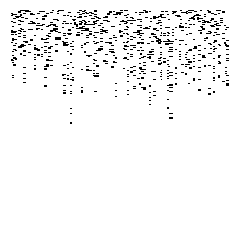

In [9]:
A = shuffSparseArray()
plot_coo_matrix(ipsort(ipsort(A)))

The plot above looks correct. The reason it didn't sort the data into squares is because the matrix wasn't generated to have squares of data in it. The function creating A generates a more random structure, thus generating a more randomized grouping when sorted. 

With all of our preliminary testing done, we are ready to sort the medical data.